### Лабораторная работа 2


### О задании

В этом задании вы:
- обучите линейную регрессию, познакомитесь с метриками качества в задачах регресии
- реализуете логистическую регрессию и её обучение градиентным спуском
- настроите метод опорных векторов, визуализируете опорные вектора
- познакомитесь с калибровочными кривыми и сравните вероятности, выдаваемые логистической регрессией и методом опорных векторов
- изучите методы работы с категориальными переменными

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

## Часть 1. Линейная регрессия

В этой части мы кратко познакомимся с линейной регрессией.

Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3.

In [2]:
data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

__Задание 1.__ Обучение линейной регрессии.



Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$). Согласуются ли результаты с вашими ожиданиями?

In [3]:
# Линейная регрессия Lasso
from sklearn.linear_model import Lasso
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

Lasso()

In [4]:
# Линейная регрессия Ridge
from sklearn.linear_model import Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

Ridge()

Посчитайте для Ridge-регрессии следующие метрики: $RMSE$, $MAE$, $R^2$.

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Функция для расчёта и вывода метрик
def PrintMetrics(model):
    # Подсчёт метрик
    rmse = sqrt(mean_squared_error(y_test, model.predict(X_test)))
    mae = mean_absolute_error(y_test, model.predict(X_test))
    r2 = r2_score(y_test, model.predict(X_test))

    # Вывод метрик
    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("R^2: ", r2)

# Вызов функции
PrintMetrics(ridge_model)

RMSE:  58.304415127748044
MAE:  49.60284607275299
R^2:  0.3598993868368464


Подберите на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Для этого воспользуйтесь GridSearchCV и KFold из sklearn. Постройте графики зависимости функции потерь от коэффициента регуляризации. Посчитайте те же метрики снова. Заметно ли изменилось качество?

In [6]:
from sklearn.model_selection import GridSearchCV, KFold

# Возвращает результат GridSearchCV
def GetGridResults(loss):
    # Логарифмическая сетка
    params = { "alpha": list(np.logspace(-3, 3)) }
    
    # Выбор метода
    score = ""
    if loss == "RMSE":
        score = "neg_root_mean_squared_error"
    elif loss == "MAE":
        score = "neg_mean_absolute_error"
    else:
        score = "r2"
    
    clf = GridSearchCV(Ridge(), params, scoring=score)
    clf.fit(X_train, y_train)
    
    # Вывод наилучшего коэффициента и всех метрик для него
    print("Best param for", loss, "is:", clf.best_params_["alpha"])
    print("Metrics for best alpha:")
    ridge_model = Ridge(alpha=clf.best_params_["alpha"])
    ridge_model.fit(X_train, y_train)
    PrintMetrics(ridge_model)
    print()
    
    # Возврат результатов
    return dict(clf.cv_results_), loss

In [7]:
# Создаёт график зависимости выбранной функции
# потерь от коэффициента регуляризации
def PlotGraphic(in_data):
    results = in_data[0]
    loss = in_data[1]
    neg_losses = ["RMSE", "MAE"]
    if loss in neg_losses:
        results["mean_test_score"] = results["mean_test_score"] * -1.0
    plt.figure(figsize=(8, 6), dpi=80)
    plt.title(loss + " test")
    plt.xlabel("Alpha")
    plt.ylabel(loss)
    plt.grid()
    plt.xscale('log')
    plt.plot(results["param_alpha"], results["mean_test_score"])

Best param for RMSE is: 0.002329951810515372
Metrics for best alpha:
RMSE:  55.812684400201015
MAE:  47.115491434298605
R^2:  0.4134417073645835

Best param for MAE is: 0.0013257113655901094
Metrics for best alpha:
RMSE:  55.843918471411044
MAE:  47.144255275236546
R^2:  0.41278502044851684

Best param for R2 is: 0.002329951810515372
Metrics for best alpha:
RMSE:  55.812684400201015
MAE:  47.115491434298605
R^2:  0.4134417073645835



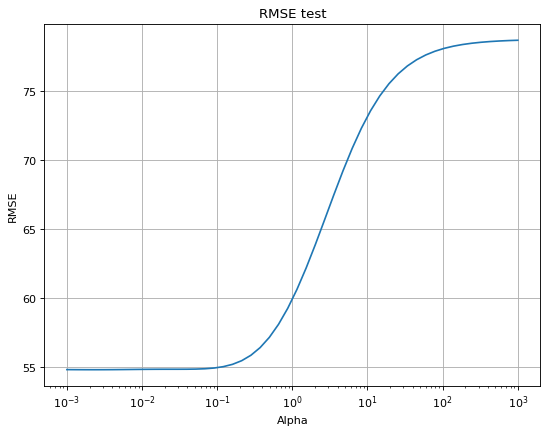

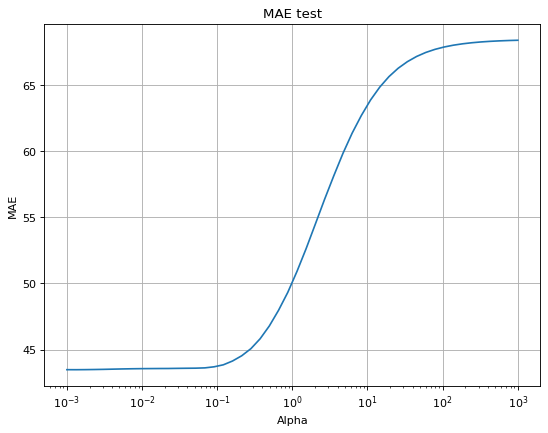

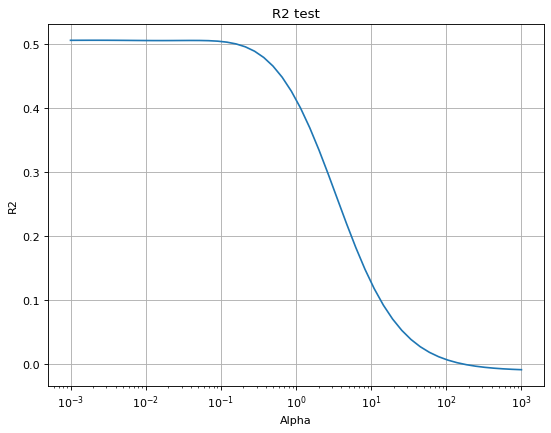

In [8]:
# Вызов функций
PlotGraphic(GetGridResults("RMSE"))
PlotGraphic(GetGridResults("MAE"))
PlotGraphic(GetGridResults("R2"))

__Задание 2.__ Поиск объектов-выбросов



Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. С помощью cross_val_predict сделайте Out-of-Fold предсказания для обучающей выборки. Посчитайте ошибки и посмотрите на их распределение (plt.hist). Что вы видите?

MSE: 3016.8852680915334


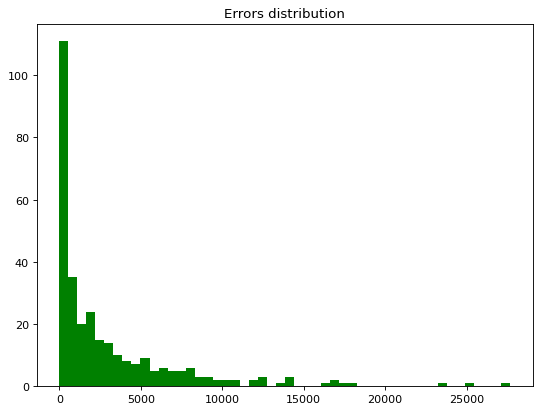

In [9]:
from sklearn.model_selection import cross_val_predict

predict = cross_val_predict(Ridge(alpha=0.00233), X_train, y_train)
mse = (y_train - predict) ** 2
# Среднеквадратическая ошибка
print("MSE:", mse.mean())
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Errors distribution")
plt.hist(mse, bins=50, color='green');

Попробуйте удалить объекты-выбросы из обучающей выборки (что считать или не считать выбросами на ваше усмотрение). Обучите модель заново и посмотрите на качество на отложенной выборке (учитывайте, что там тоже могут быть выбросы, с которыми вы ничего не можете сделать). Стало ли лучше? Чем вы можете объяснить это?

Train MSE: 1168.3635945929245
Test MSE: 3129.056626188991


Text(0.5, 1.0, 'Test errors distribution')

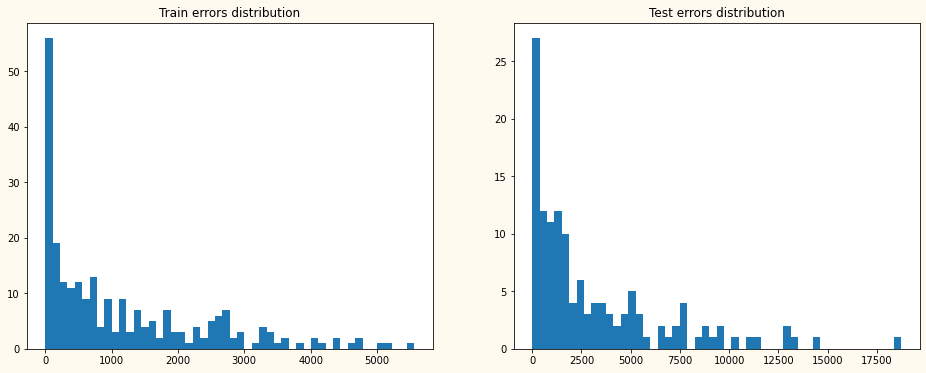

In [10]:
# Ограничиваем обучающую выборку
limit = 5000
X_train_slct = X_train[mse <= limit]
y_train_slct = y_train[mse <= limit]

# Заново обучаем модель на новой выборке
model = Ridge(alpha=0.00233)
model.fit(X_train_slct, y_train_slct)

'''
 Получаем предсказания модели и 
 расчитываем среднеквадратичную ошибку
 для обучающей и тестовой выборок
'''
train_preds = model.predict(X_train_slct)
test_preds = model.predict(X_test)
mse_slc = (y_train_slct - train_preds) ** 2
mse_test = (y_test - test_preds) ** 2
print("Train MSE:", mse_slc.mean())
print("Test MSE:", mse_test.mean())

# Выводим графики распределения ошибок
fig, axs = plt.subplots(1, 2)
fig.set_facecolor('floralwhite')
fig.set_figwidth(16)
fig.set_figheight(6)
axs[0].hist(mse_slc, bins=50)
axs[0].set_title("Train errors distribution")
axs[1].hist(mse_test, bins=50)
axs[1].set_title("Test errors distribution")

__Выводы:__ лучше не стало в связи с тем, что в тесте все еще много выбросов, необоходимо реализовывать устойчивые к выбросам модели, так как в реальных условиях невозможно повлиять на зашумленность данных

## Часть 2. Логистическая регрессия

В этой части мы будем реализовывать один из самых простых бинарных классификаторов — логистическую регрессию и её обучение с помощью обычного (полного) и стохастического градиентных спусков.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). В случае стохастического градиентного спуска $\nabla_w Q(w, X) \approx \nabla_w q_{i_k} (w)$, где $i_k$ — случайно выбранный номер слагаемого из функционала (регуляризатор можно внести в сумму, предварительно умножив и разделив на $l$). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Формулу для градиента функции потерь логистической регрессии вы должны были выводить в рамках одной из задач четвёртого теоретического домашнего задания. Но на всякий случай мы её повторим. Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Вероятность принадлежности объекта $x$ классу $+1$ вычисляется следующим образом:

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- \langle w, x \rangle )}
$$

Не забывайте, что матрицу объекты-признаки $X$ необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из 2 способов, разобранных на лекциях). Для этого можно воспользоваться StandardScaler или сделать это вручную.

В логистической регрессии также можно использовать $L_1$-регуляризацию. Тогда в функцию потерь добавится слагаемое $\lambda_1 \lVert w \rVert _1$. В формуле для вычисления градиента фукнции потерь по вектору коэффициентов это слагаемое будет соответствовать $\lambda_1 sgn(w)$, где $sgn$ — вычисление знака числа, применяемое к вектору коэффициентов поэлементо.

__Задание 1.__ Реализация обучения и применения логистической регресии c $L_2$-регуляризацией. 



Используйте для этого указанные ниже прототипы. Для эффективности все вычисления производите в векторизованной форме без циклов (кроме самих итераций градиентного спуска). Сгенерируйте с помощью функции make\_classification из модуля sklearn.datasets небольшую выборку для тестирования и исследования (выборка не должна быть слишком простой для классификации; также не забудьте проверить, что метки объектов из необходимого нам множества). Постройте следующие графики (для полного и стохастического градиентного спуска на одном графике):
- функции потерь от номера итерации обучения
- затраченного времени от номера итерации обучения

Возьмите параметр регуляризации $\lambda_2=1$, точность $tolerance=10^{-6}$, максимальное число итераций $max\_iter=1000$. Подберите оптимальную на ваш взгляд величину шага градиентного спуска. 

Сделайте выводы о том, чем различается на практике обучение с помощью стохастического градиентного спуска по сравнению с полным градиентным спуском.

В этом задании не обращайте внимания на $\lambda_1$, соответствующий $L_1$-регуляризации.

Для численной устойчивости вам могут быть полезны функции: scipy.special.expit и numpy.logaddexp.

__Бонусное задание.__ Реализация $L_1$-регуляризации и обучение с помощью субградиентного спуска.

Модифицируйте реализацию так, чтобы можно было обучать логистическиую регрессию с $L_1$-регуляризацией (и даже одновременно с двумя видами). Проведите аналогичные эксперименты, считая $\lambda_1 = 0.001, \lambda_2 = 0$.

Стоит помнить, что модуль — недифференцируемая в нуле функция, поэтому мы не можем применить обычный градиентный спуск. Вместо этого будем применить субградиентный спуск — аналогичный градиентному спуску метод, в котором используется субградиент функции. 

Вектор $g \in \mathbb{R}$ называется субградиентом выпуклой функции $f$ в точке $x$, если $\forall z \in \mathbb{R}$ выполнено неравенство: $f(z) \ge f(x) + g^T (z-x)$. Если функция $f$ дифференцируема в точке $x$, её субградиент в этой точке совпадает с градиентом. Субдифференциалом функции $f$ называют множество субградиентов в этой точке.

Для $f(x) = |x|$ при $x = 0$ субдифференциал определяется неравенством $|z| \ge gz$, поэтому $g \in [-1, 1]$. 

На практике для стабильности процесса обучения для близких к нулю значений можно уменьшать градиент, умножая на небольшое число (например, 0.1-0.5) или делая его нулевым (только околонулевые координаты!)

In [11]:
from time import time

class LogReg(BaseEstimator):
    def __init__(self, lambda_1=0.0, lambda_2=1.0, gd_type='stochastic', 
                 tolerance=1e-6, max_iter=1000, w0=None, alpha=1e-3, verbose=0):
        """
        lambda_1: L1 regularization param
        lambda_2: L2 regularization param
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.loss_history = None
        self.time_history = None
        self.verbose = verbose
    
    def fit(self, X: np.array, y: np.array):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        self.time_history = np.zeros(self.max_iter)
        l, d = X.shape
        y = y.reshape(-1, 1)
        st_index = 0
        
        if self.w is None:
            self.w = 0.1 * np.random.rand(d, 1)
        
        for i in range(self.max_iter):
            start = time()
            if self.gd_type == "stochastic":
                grad = self.calc_gradient(X[st_index].reshape((1, d)), y[st_index])
                st_index = (st_index + 1) % l
            else:
                grad = self.calc_gradient(X, y)

            grad *= self.alpha
            self.w -= grad

            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            end = time()
            self.time_history[i] = (end - start)

            if np.linalg.norm(grad) < self.tolerance and i > 5:
                print("learning has stopped at iteration", i)
                break

            if self.verbose:
                print("loss:", loss)

        return self
    
    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        reg = self.lambda_2 * self.w
        tmp = -np.sum((y * X) / (1 + np.exp(y * (X @ self.w))), axis=0).reshape(-1, 1)
        gradient = 1 / X.shape[0] * tmp + reg
        return gradient

    def calc_loss(self, X: np.array, y: np.array) -> float:
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        reg = self.lambda_2 / 2 * np.sum(self.w ** 2)
        k = np.log(1 + np.exp(-y * (X @ self.w)))
        return 1 / X.shape[0] * np.sum(k) + reg
    
    def predict_proba(self, X: np.array) -> np.array:
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception("Not trained yet")
        else:
            probs = 1 / (1 + np.exp(-X @ self.w))
            return np.concatenate([1 - probs, probs], axis=1)
    
    def predict(self, X: np.array) -> np.array:
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 1) where
        first column has predicted labels of samples from X
        """
        return self.predict_proba(X).argmax(axis=1)
    
    def score(self, X: np.array, y: np.array) -> float:
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: default accuracy score
        """
        preds = self.predict(X)
        return (preds.reshape(-1) == y).mean()

In [12]:
from sklearn.datasets import make_classification

# Сформируем датасет
X, target = make_classification(n_samples=1000)
y = target.copy()
y[y == 0] = -1
X = (X - X.mean()) / X.std()

In [13]:
# Обучаем модель стохастическим градиентным спуском
model_stoch = LogReg(alpha=0.0005, lambda_2=1, gd_type="stochastic")
model_stoch.fit(X, y)
print("Stochastic model score: ", model_stoch.score(X, target))

# Обучаем модель полным градиентным спуском
model_full = LogReg(alpha=0.001, lambda_2=1, gd_type="full")
model_full.fit(X, y)
print("Full model score: ", model_full.score(X, target))

Stochastic model score:  0.785
Full model score:  0.861


Text(0.5, 1.0, 'Time in train')

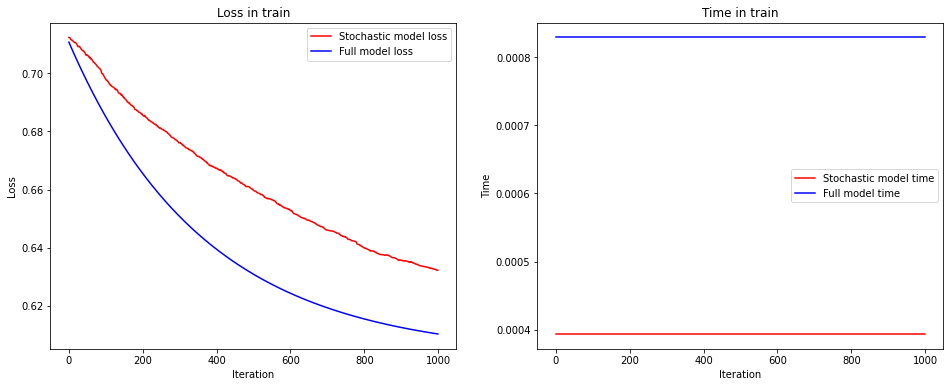

In [14]:
# Выводим графики 
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(6)

# Зависимость функции потерь от номера итерации обучения
axs[0].plot(model_stoch.loss_history, label="Stochastic model loss", color="red")
axs[0].plot(model_full.loss_history, label="Full model loss", color="blue")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].set_title("Loss in train")

# Зависимость затраченного времени от номера итерации обучения (взято среднее значение)
axs[1].plot(np.full(1000, model_stoch.time_history.mean()), label="Stochastic model time", color="red")
axs[1].plot(np.full(1000, model_full.time_history.mean()), label="Full model time", color="blue")
#axs[1].plot(model_stoch.time_history, label="Stochastic model time", color="red")
#axs[1].plot(model_full.time_history, label="Full model time", color="blue")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Time")
axs[1].legend()
axs[1].set_title("Time in train")

__Выводы:__ модель со *стохастическим* градиентным спуском обучается быстрее модели с *полным* градиентным спуском, но имеет меньшую точность по сравнению с *полным*.

__Задание 2.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.



Полезные функции и классы из scikit-learn для этого задания: confusion_matrix, precision_recall_curve, average_precision_score, train_test_split, StandardScaler, roc-curve, roc_auc_score.

Загрузим данные с актуального сейчас конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [15]:
# Читаем данные датасета
data = pd.read_csv("data_for_lab_2.csv", index_col=0)
target = data.target.values
data = data.drop("target", axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [16]:
# Ресэмплинг
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)
data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [17]:
from sklearn.preprocessing import StandardScaler

# Нормировка признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train_slct = y_train.copy()
y_train_slct[y_train_slct == 0] = -1
y_test_slct = y_test.copy()
y_test_slct[y_test_slct == 0] = -1

print(X_train.shape)
print(y_train_slct.shape)

(100000, 57)
(100000,)


Обучите логистическую регрессию с удобными для вас параметрами. Сделайте предсказание на тестовой части выборки.

In [18]:
# Обучение
model = LogReg(alpha=0.005, lambda_2=0.9, max_iter=1000, gd_type="full")
model.fit(X_train, y_train_slct)
print("Model score:", model.score(X_test, y_test))

Model score: 0.58696


In [19]:
# Предсказание на тестовой выборке
predictions = model.predict_proba(X_test)[:, 1]
print(predictions)
print(predictions.shape)

[0.49582431 0.59979672 0.49242758 ... 0.51513855 0.52882253 0.45292304]
(100000,)


Постройте ROC-кривую и Precision-Recall-кривую, посчитайте ROC-AUC и PR-AUC. Какие наблюдения и выводы по ним можно сделать? (В свободной форме)

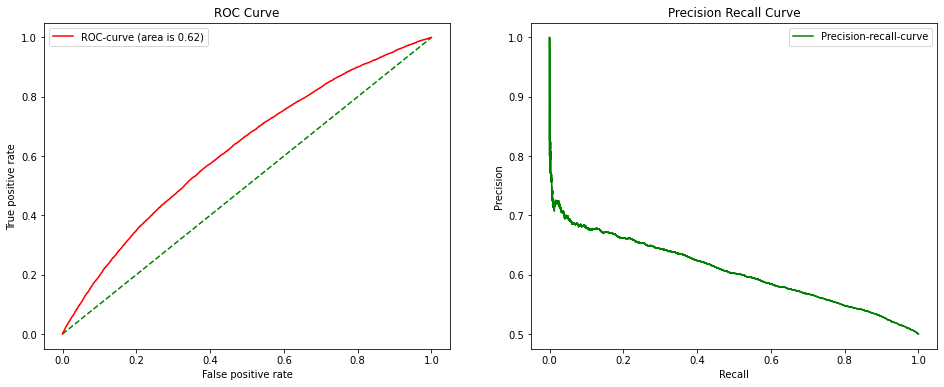

In [20]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Выводим графики 
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(6)

# ROC-кривая
fpr, tpr, thr = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
axs[0].plot([0, 1], [0, 1], color="green", linestyle='--')
axs[0].plot(fpr, tpr, label="ROC-curve (area is %0.2f)" % roc_auc, color="red")
axs[0].set_xlabel("False positive rate")
axs[0].set_ylabel("True positive rate")
axs[0].legend()
axs[0].set_title("ROC Curve")

# Precision-Recall-кривая
pr, re, thr = precision_recall_curve(y_test, predictions)
axs[1].plot(re, pr, label="Precision-recall-curve", color="green")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()
axs[1].set_title("Precision Recall Curve")
plt.show()

Предположим, что наш алгоритм должен обеспечивать полноту не менее 0.7. Какому порогу бинаризации вероятностей это будет соответствовать? Какую точность (precision) мы получим? Постройте матрицу ошибок для данного порога. Что вы можете сказать о таком алгоритме? (В свободной форме)

In [21]:
from sklearn.metrics import confusion_matrix

# Точность для полноты 0.7
i = 28264
threshold = thr[i]
print("Recall:", re[i], "\nPrecision:", pr[i], "\nThreshold:", threshold)

# Матрица ошибок
print("\nConfusion matrix:", confusion_matrix(y_test, predictions >= threshold), sep="\n")

Recall: 0.6999160100787906 
Precision: 0.5677578431690621 
Threshold: 0.4817034276785926

Confusion matrix:
[[23348 26646]
 [15006 35000]]


__Задание 3.__ Изучение влияния регуляризатора на процесс обучения



Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

In [22]:
# Повторная выборка
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)
data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)
y_train_inverse = (y_train == 1) * -1 + (y_train == 0) * 1
y_test_inverse = (y_test == 1) * -1 + (y_test == 0) * 1

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Функция для отображения графика
@ignore_warnings(category=ConvergenceWarning)
def PlotLossRegularization(reg_coef):
    fig = plt.figure(figsize=(20, 10))
    plt.title("Regularization Strength Influence")
    plt.xlabel("Iterations")
    plt.ylabel("Loss function")
    plt.xlim([0, 1000])
    plt.grid()
    loss_func_train = np.zeros(1000)
    loss_func_test = np.zeros(1000)
    log_reg = LogisticRegression(penalty='l2', C=reg_coef, solver='lbfgs',
                                 max_iter=1, warm_start=True, l1_ratio=None, tol=0.0001)

    for i in range(1000):
        log_reg.fit(X_train, y_train)
        loss_func_train[i] = (0.5 * np.sum(log_reg.coef_.ravel() ** 2) +
                             reg_coef * np.sum(np.log(np.exp(y_train_inverse *
                             (np.matmul(X_train.to_numpy(), log_reg.coef_.ravel()) + log_reg.intercept_)) + 1)))
        loss_func_test[i] = (0.5 * np.sum(log_reg.coef_.ravel() ** 2) +
                             reg_coef * np.sum(np.log(np.exp(y_test_inverse *
                             (np.matmul(X_test.to_numpy(), log_reg.coef_.ravel()) + log_reg.intercept_)) + 1)))

    plt.plot(loss_func_train, color="red", ls='-', label=f'С={reg_coef}, train set')
    plt.plot(loss_func_test, color="blue", ls='--', label=f'C={reg_coef}, test set')
    plt.legend()
    plt.show()

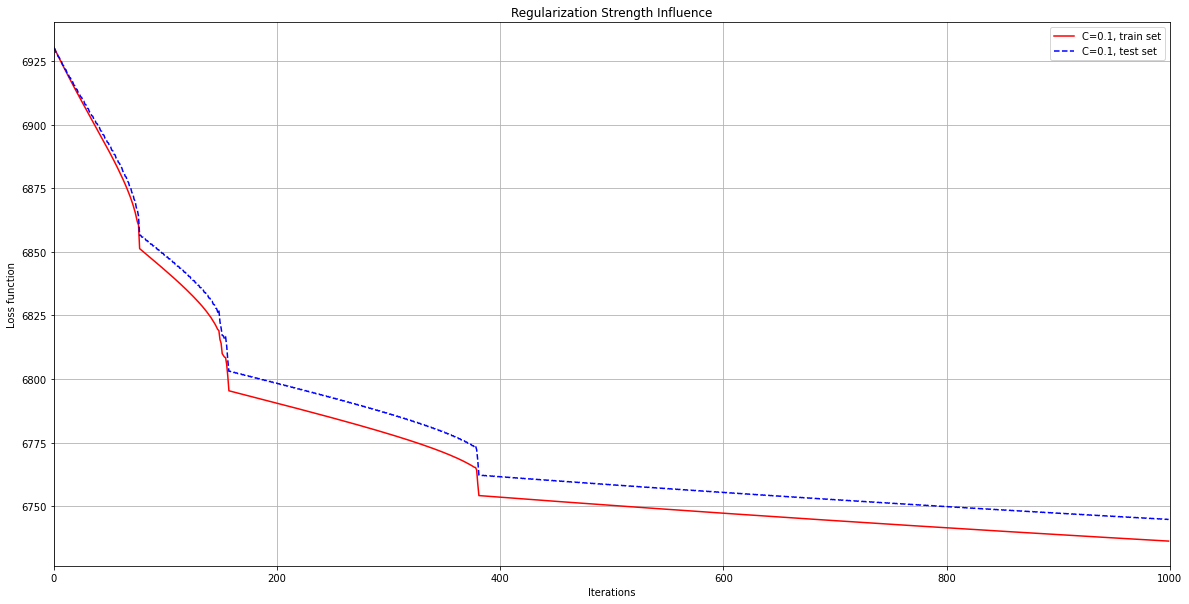

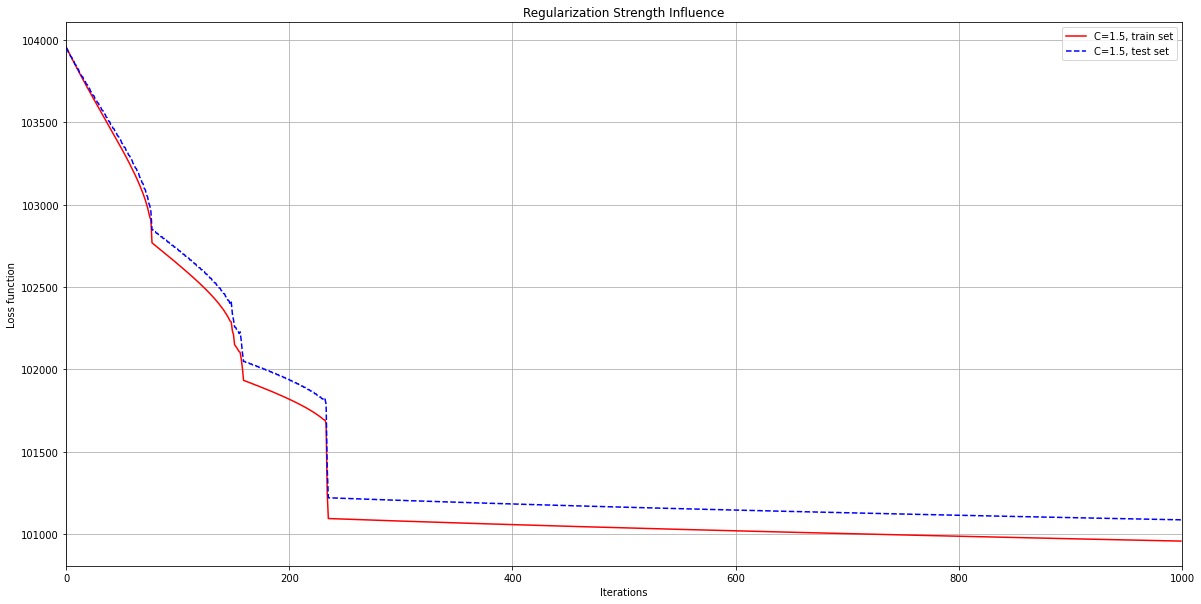

In [24]:
# Вывод графиков
PlotLossRegularization(0.1)
PlotLossRegularization(1.5)

## Часть 3. Метод опорных векторов и калибровка вероятностней

__Задание 1.__ Обучение и применение метода опорных векторов.



Обучите метод опорных векторов (в этот раз воспользуйтесь готовой реализацией LinearSVC из sklearn). Используйте уже загруженные и обработанные в предыдущей части данные.

In [25]:
from sklearn.svm import LinearSVC

# Сформируем датасет
X, y = make_classification(n_samples=100000, n_features=20, n_informative=10, n_redundant=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучим нейросеть
linear_svc = LinearSVC(loss='squared_hinge', dual=True, C=1.0, max_iter=100000)
linear_svc.fit(X_train, y_train)

LinearSVC(max_iter=100000)

In [26]:
# Предсказание по тестовой выборке
predictions = linear_svc.predict(X_test).T
print(predictions.shape, predictions, sep="\n")

(30000,)
[1 1 1 ... 1 1 1]


На той же тестовой части посчитайте все те же метрики. Что вы можете сказать о полученных результатах?

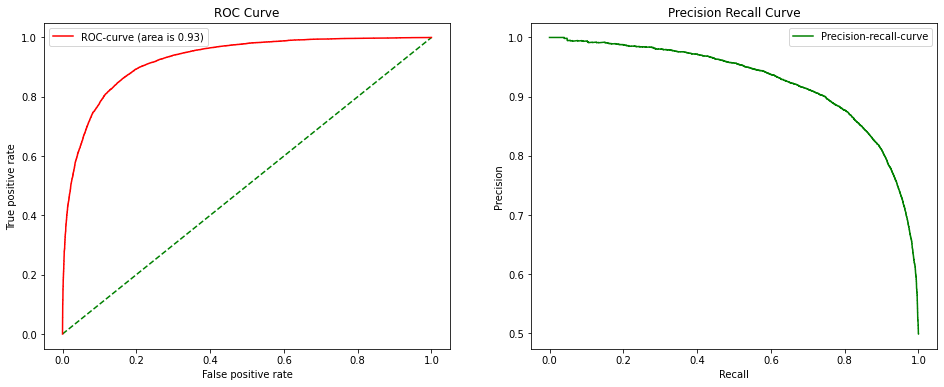

In [27]:
from sklearn.metrics._plot.base import _get_response

# Выводим графики 
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(6)
predictions, _ = _get_response(X_test, linear_svc, "auto")

# ROC-кривая
fpr, tpr, thr = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
axs[0].plot([0, 1], [0, 1], color="green", linestyle='--')
axs[0].plot(fpr, tpr, label="ROC-curve (area is %0.2f)" % roc_auc, color="red")
axs[0].set_xlabel("False positive rate")
axs[0].set_ylabel("True positive rate")
axs[0].legend()
axs[0].set_title("ROC Curve")

# Precision-Recall-кривая
precision, recall, _ = precision_recall_curve(y_test, predictions)
axs[1].plot(recall, precision, label="Precision-recall-curve", color="green")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()
axs[1].set_title("Precision Recall Curve")
plt.show()

В названии метода присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов с линейным ядром. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support\_vectors\_). В этот раз вместо LinearSVC воспользуйтесь SVC с линейным ядром, так как только в нём есть информация об опорных векторах.

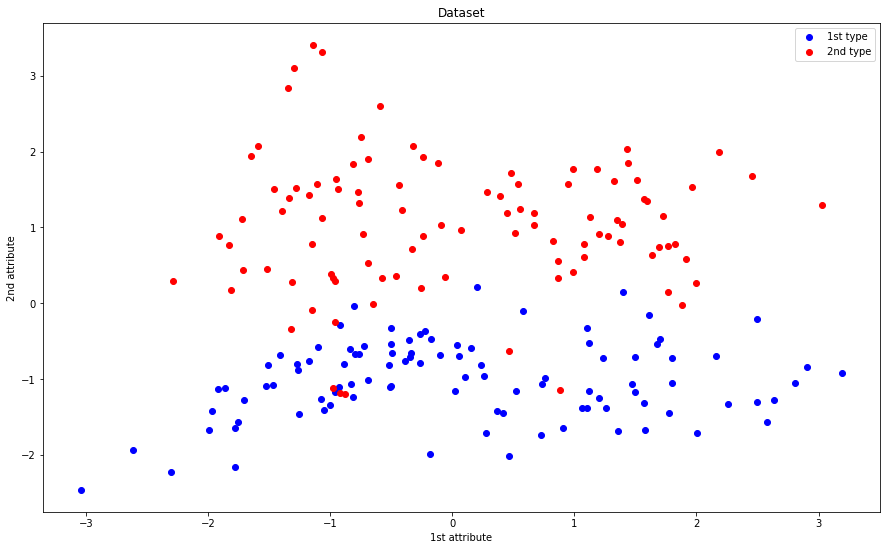

In [28]:
from sklearn.svm import SVC

# Генерируем датасет
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_classes=2, class_sep=1.0)

# Отображаем датасет на графике
fig = plt.figure(figsize=(15, 9))
plt.scatter(X[y == 0, 0].ravel(), X[y == 0, 1].ravel(), color="blue", label="1st type")
plt.scatter(X[y == 1, 0].ravel(), X[y == 1, 1].ravel(), color="red", label="2nd type")
plt.legend()
plt.xlabel("1st attribute")
plt.ylabel("2nd attribute")
plt.title("Dataset")
plt.show()

In [29]:
# Обучаем SVC с линейным ядром
svc = SVC(C=1.0, kernel='linear')
svc.fit(X, y)

SVC(kernel='linear')

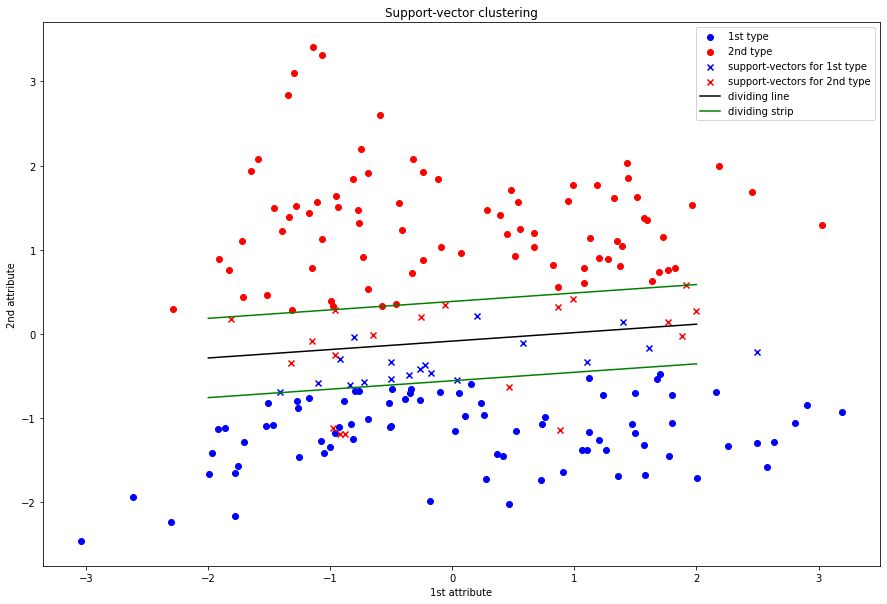

In [30]:
import math

# Визуализация работы метода опорных векторов
X_not_sup = X[np.delete(np.arange(X.shape[0]), svc.support_)]
y_not_sup = y[np.delete(np.arange(y.shape[0]), svc.support_)]
plt.figure(figsize=(15, 10))
plt.title("Support-vector clustering")
plt.xlabel("1st attribute")
plt.ylabel("2nd attribute")

plt.scatter(X_not_sup[y_not_sup == 0, 0].ravel(),
            X_not_sup[y_not_sup == 0, 1].ravel(),
            color="blue", label="1st type")
plt.scatter(X_not_sup[y_not_sup == 1, 0].ravel(),
            X_not_sup[y_not_sup == 1, 1].ravel(),
            color="red", label="2nd type")
plt.scatter(X[svc.support_][y[svc.support_] == 0, 0].ravel(),
            X[svc.support_][y[svc.support_] == 0, 1].ravel(),
            color="blue", marker='x', label="support-vectors for 1st type")
plt.scatter(X[svc.support_][y[svc.support_] == 1, 0].ravel(),
            X[svc.support_][y[svc.support_] == 1, 1].ravel(),
            color="red", marker='x', label="support-vectors for 2nd type")

plt.plot([-2, 2],[(2 * svc.coef_[0, 0] - svc.intercept_) / svc.coef_[0, 1],
         -(2 * svc.coef_[0, 0] + svc.intercept_) / svc.coef_[0, 1]], color="black", label="dividing line") # прямая
plt.plot([-2, 2], [(2 * svc.coef_[0, 0] - svc.intercept_) / svc.coef_[0, 1] - 1 / math.fabs(svc.coef_[0, 1]),
         -(2 * svc.coef_[0, 0] + svc.intercept_) / svc.coef_[0, 1] - 1 / math.fabs(svc.coef_[0, 1])],
         color="green", label="dividing strip") # полоса
plt.plot([-2, 2], [(2 * svc.coef_[0, 0] - svc.intercept_) / svc.coef_[0, 1] + 1 / math.fabs(svc.coef_[0, 1]),
         -(2 * svc.coef_[0, 0] + svc.intercept_) / svc.coef_[0, 1] + 1 / math.fabs(svc.coef_[0, 1])], color="green")
plt.legend()
plt.show()

__Задание 2.__ Калибровка вероятностей.



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [31]:
def plot_calibration_curve(y_test, preds, title):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        #bin_middle_points.append((l - r) / 2) # Было
        bin_middle_points.append((l + r) / 2) # Стало
        #bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1)) # Было
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / np.sum((preds >= l) & (preds < r))) # Стало
    plt.figure(figsize=(15, 10))
    plt.title("Calibration Curve for " + title)
    plt.xlabel("Midpoints of lines on [0, 1]")
    plt.ylabel("2nd type percent")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid()
    plt.plot(bin_middle_points, bin_real_ratios, label="Calibration curve")
    plt.show()

Посмотройте калибровочные кривые для логистической регрессии и метода опорных векторов (на той же самой выборке с тем же самым разбиением — можно использовать уже полученные ранее предсказания). Изучите распределение ответов классификаторов (постройте гистограммы с помощью plt.hist). Чем они различаются? Чем вы можете объяснить это?

Заметим, что метод опорных векторов не умеет predict_proba, но имеет метод decision_function.

In [32]:
from sklearn.linear_model import LogisticRegression

# Формируем новый датасет
X, y = make_classification(n_samples=100000, n_features=20, n_informative=10, n_redundant=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем логистическую регрессию
log_reg = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=100)
log_reg.fit(X_train, y_train)

# Обучаем метод опорных векторов
linear_svc = LinearSVC(loss='squared_hinge', dual=True, C=1.0, max_iter=100000)
linear_svc.fit(X_train, y_train)

LinearSVC(max_iter=100000)

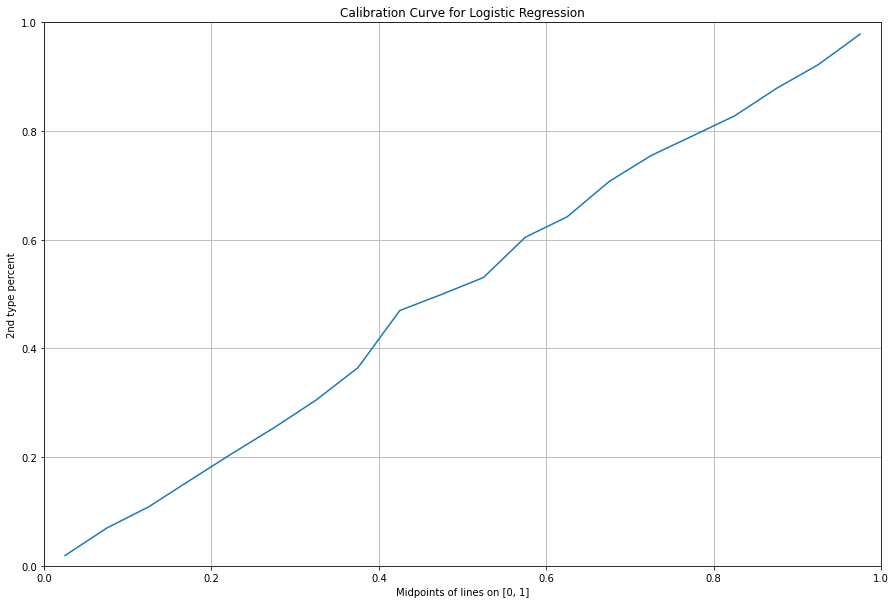

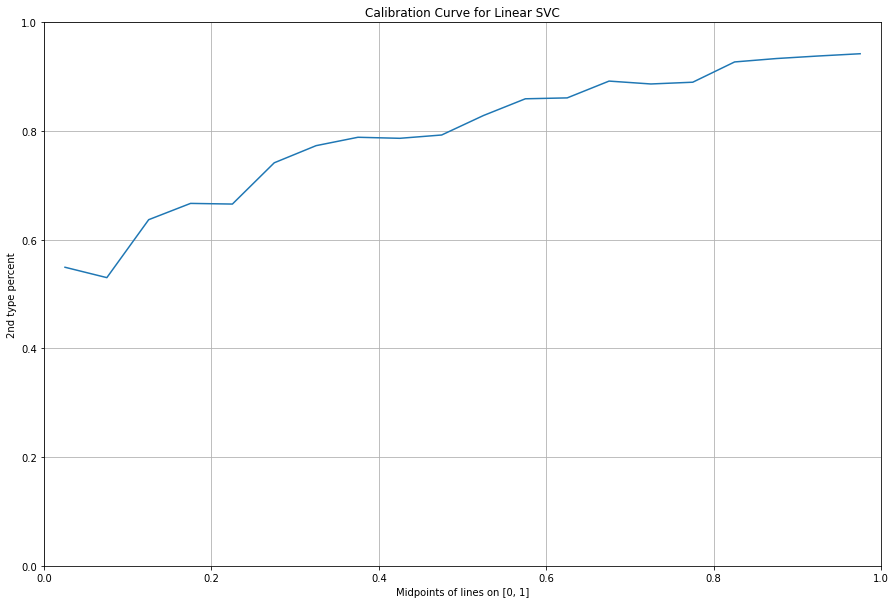

In [33]:
# Отображаем графики с калибровочными кривыми
plot_calibration_curve(y_test, log_reg.predict_proba(X_test)[:, 1], "Logistic Regression")
plot_calibration_curve(y_test, linear_svc.decision_function(X_test), "Linear SVC")

In [34]:
# Функция для отображения гистограммы распределения ответов
def plot_hist_distribution(preds, title, color="green"):
    plt.figure(figsize=(15, 7))
    plt.title("Predict distribution for " + title)
    if (title == "Logistic Regression"):
        plt.xlabel("Probability to 2nd type")
    else:
        plt.xlabel("Discriminant function")
    plt.ylabel("Number")
    if (title == "Logistic Regression"):
        plt.xticks(np.arange(0, 1.1, 0.1))
    plt.grid()
    plt.hist(preds, bins=50, color=color)
    plt.show()

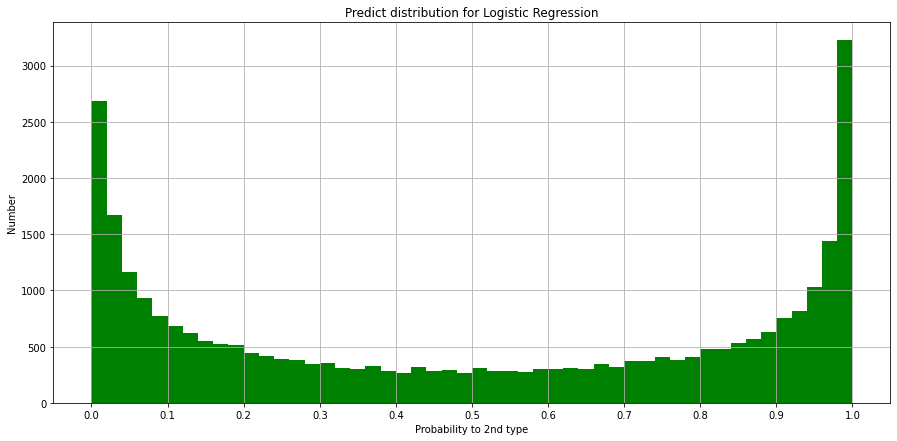

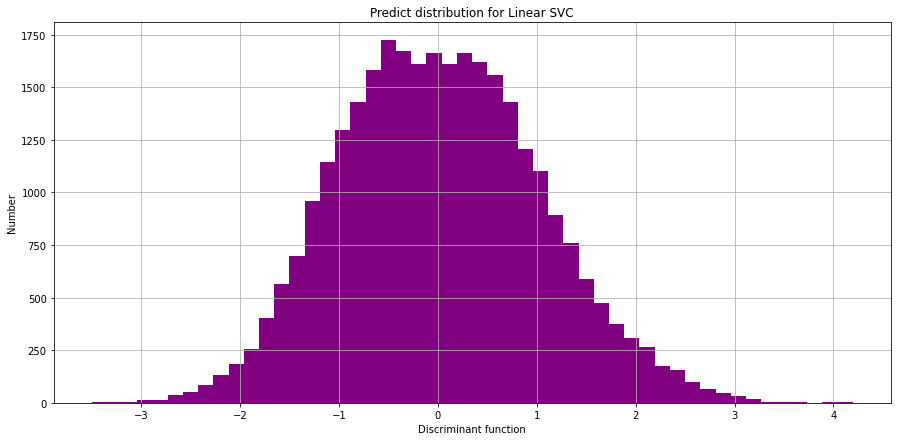

In [35]:
# Отображаем графики с распределениями ответов
plot_hist_distribution(log_reg.predict_proba(X_test)[:, 1], "Logistic Regression")
plot_hist_distribution(linear_svc.decision_function(X_test), "Linear SVC", "purple")

__Выводы:__
Калибровочная кривая логистической регрессии показывает высокое качество предсказания вероятностей. Калибровочная кривая метода опорных векторов показывает очень плохое качество, потому что дискриминантная функция метода опорных векторов выдает не вероятности принадлежности к положительному классу.

Распределение ответов классификаторов различается тем, что у метода опорных векторов есть отрицательные значения. В методе опорных векторов чем больше по модулю значение дискриминантной функции, тем алгоритм более уверен в принадлежности объекта соответствующему классу. По распределению ответов SVC видно, что классы слабо разделимы, почти все значения дискриминантной функции содержатся на отрезке от -2 до 2.

У логистической регрессии распределение ответов тем лучше, чем оно больше по краям. Потому что в таком случае алгоритм с большей уверенностью относит объекты к классам. В нашем распределении наблюдается именно такая ситуация.

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [36]:
from sklearn.calibration import CalibratedClassifierCV

# Обучение методом опорных векторов с калибровкой
linear_svc_calib = CalibratedClassifierCV(linear_svc, method='sigmoid', cv='prefit')
linear_svc_calib.fit(X_train, y_train)

# Предсказания для тестовой выборки
predicts = linear_svc_calib.predict_proba(X_test)
print("Predicts: ", predicts, sep="\n")

Predicts: 
[[0.43205998 0.56794002]
 [0.12738919 0.87261081]
 [0.02683631 0.97316369]
 ...
 [0.47266847 0.52733153]
 [0.34593095 0.65406905]
 [0.2349478  0.7650522 ]]


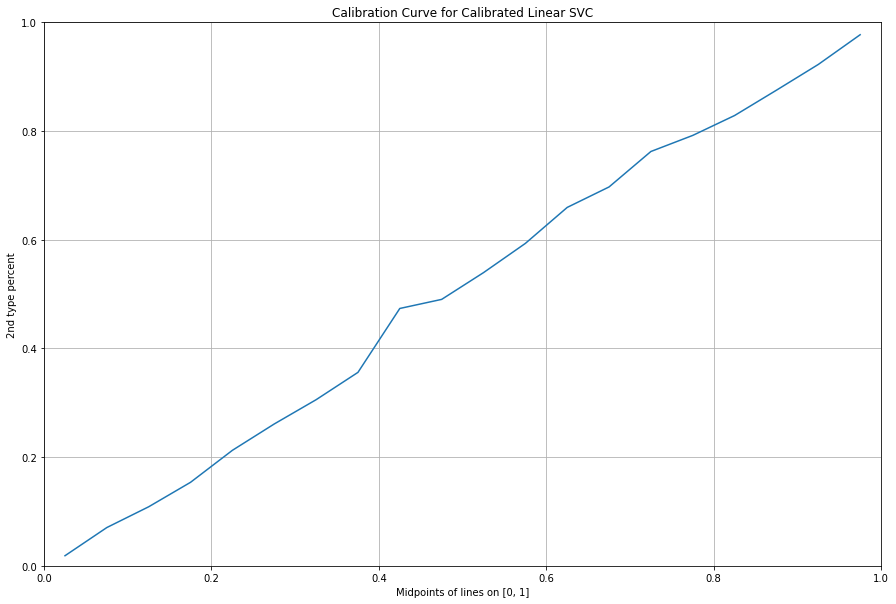

In [37]:
# Отображение графика калибровочной кривой для
# откалиброванного метода опорных векторов
plot_calibration_curve(y_test, linear_svc_calib.predict_proba(X_test)[:, 1], "Calibrated Linear SVC")

__Вывод:__ Калибровочная прямая улучшилась после применения к опорным векторам калибровки

## Часть 4. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.



In [38]:
# Читаем данные датасета
data = pd.read_csv("data_for_lab_2.csv", index_col=0)
target = data.target.values
data = data.drop("target", axis=1)

# Ресэмплинг
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)
data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

In [39]:
from sklearn.preprocessing import OneHotEncoder

# Кодируем признаки
one_hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_one_hot = np.hstack(
    (one_hot_enc.fit_transform(X_train[list(filter(lambda x: x.endswith('cat'), X_train.columns))].to_numpy()),
    X_train[list(filter(lambda x: not x.endswith('cat'), X_train.columns))].to_numpy()))
X_test_one_hot = np.hstack((one_hot_enc.transform(X_test[list(filter(lambda x: x.endswith('cat'), X_test.columns))].to_numpy()),
    X_test[list(filter(lambda x: not x.endswith('cat'), X_test.columns))].to_numpy()))

# Создаём модель для логистической регрессии
log_reg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)

In [40]:
%%time

# Обучаем модель и замеряем время, потраченное на обучение
log_reg.fit(X_train_one_hot, y_train)

CPU times: total: 1min 19s
Wall time: 36 s


LogisticRegression(C=0.1, max_iter=10000)

In [41]:
from sklearn.metrics import roc_auc_score

# Качество новой модели
res = log_reg.predict_proba(X_test_one_hot)
print(roc_auc_score(y_test, res[:, 1]))

0.63324791951877


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?



In [42]:
# Разделяет набор данных на k последовательность сгибов
def kfold(k: int, k_folds: int):
    if k < 1 or k_folds < 2:
        raise AttributeError('Incorrect parameters')

    index_list = []
    d = k // k_folds
    for i in range(k_folds - 1):
        arr_val = np.arange(i * d, (i + 1) * d)
        arr_train = np.hstack((np.arange(0, i * d), np.arange((i + 1) * d, k)))
        index_list.append((arr_train, arr_val))
    index_list.append((np.arange((k_folds - 1) * d), np.arange((k_folds - 1) * d, k)))
    return index_list

In [48]:
# Счётчики
def counters(X_train, y_train, X_test, features, num_folds=None, timing=False):
    if timing:
        for feature in features:
            X_train[feature], X_test[feature] = counters_maker_timing(X_train[feature].to_numpy().flatten(),
                                                                      X_test[feature].to_numpy().flatten(),
                                                                      y_train)
    elif num_folds is not None:
        for feature in features:
                X_train[feature], X_test[feature] = counters_maker_folding(X_train[feature].to_numpy().flatten(),
                                                                           X_test[feature].to_numpy().flatten(),
                                                                           y_train, num_folds)
    else:
        for feature in features:
            X_train[feature], X_test[feature] = counters_maker(X_train[feature].to_numpy().flatten(),
                                                               X_test[feature].to_numpy().flatten(),
                                                               y_train)

In [44]:
# Функция для создания счётчиков
def counters_maker(x_train_feature, x_test_feature, target, a=0, b=0):
    categories, counts = np.unique(x_train_feature, return_counts=True)
    categories_cond, counts_cond = np.unique(x_train_feature[target == 1], return_counts=True)
    categories_test = np.unique(x_test_feature)
    x_train_res, x_test_res = np.empty(x_train_feature.shape[0], dtype=np.float64), \
                              np.full(x_test_feature.shape[0], -1, dtype=np.float64)

    for cat in categories:
        if np.any(categories_cond == cat):
            res = (counts_cond[categories_cond == cat][0] + a) / (counts[categories == cat][0] + b)
            x_train_res[x_train_feature == cat] = res
        else:
            res = a / (counts[categories == cat][0] + b)
            x_train_res[x_train_feature == cat] = res

        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    x_test_res[x_test_res == -1.0] = 0.5
    return x_train_res, x_test_res

In [45]:
# Функция для создания счётчиков складывания
def counters_maker_folding(x_train_feature, x_test_feature, target, num_folds, c=10):
    index_list = kfold(x_train_feature.shape[0], num_folds)
    x_test_res = np.full(x_test_feature.shape[0], -1, dtype=np.float64)
    x_train_res = np.array([], dtype=np.float64)
    for index in index_list:
        categories, counts = np.unique(x_train_feature[index[0]], return_counts=True)
        categories_cond, counts_cond = np.unique(x_train_feature[index[0]][target[index[0]] == 1], return_counts=True)
        categories_fold = np.unique(x_train_feature[index[1]])
        x_fold_tmp = np.full(index[1].shape[0], -1, dtype=np.float64)
        global_mean = np.mean(target[index[0]])
        for cat in categories:
            if np.any(categories_cond == cat):
                res = (counts_cond[categories_cond == cat][0] + c * global_mean) / (counts[categories == cat][0] + c)
            else:
                res = c * global_mean / (counts[categories == cat][0] + c)

            if np.any(categories_fold == cat):
                x_fold_tmp[x_train_feature[index[1]] == cat] = res

        x_fold_tmp[x_fold_tmp == -1.0] = global_mean
        x_train_res = np.append(x_train_res, x_fold_tmp)

    categories, counts = np.unique(x_train_feature, return_counts=True)
    categories_cond, counts_cond = np.unique(x_train_feature[target == 1], return_counts=True)
    categories_test = np.unique(x_test_feature)
    global_mean = np.mean(target)
    for cat in categories:
        if np.any(categories_cond == cat):
            res = (counts_cond[categories_cond == cat][0] + c * global_mean) / (counts[categories == cat][0] + c)
        else:
            res = c * global_mean / (counts[categories == cat][0] + c)

        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    x_test_res[x_test_res == -1.0] = global_mean
    return x_train_res, x_test_res

In [46]:
# Функция для создания счётчиков синхронизации
def counters_maker_timing(x_train_feature, x_test_feature, target):
    cat_train = np.unique(x_train_feature)
    x_train_res = np.empty(x_train_feature.shape[0], dtype=np.float64)
    x_train_res[0] = 0.5
    for cat in np.unique(x_test_feature):
        if np.any(cat_train == cat):
            x_test_feature[x_test_feature == cat] = np.sum(target[x_train_feature == cat]) / np.sum(x_train_feature == cat)
        else:
            x_test_feature[x_test_feature == cat] = 0.5
    for i in range(1, x_train_res.shape[0]):
        if np.any(x_train_feature[i] == x_train_feature[0:i]):
            x_train_res[i] = np.sum(target[0:i][x_train_feature[0:i] == x_train_feature[i]]) / np.sum(x_train_feature[0:i] == x_train_feature[i])
        else:
            x_train_res[i] = 0.5
    return x_train_res, x_test_feature

In [49]:
# Создание счётчиков
X_train_counter1 = X_train.copy()
X_test_counter1 = X_test.copy()
counters(X_train_counter1, y_train, X_test_counter1, filter(lambda x: x.endswith('cat'), X_train.columns))

for cat_feature in filter(lambda x: x.endswith('cat'), X_train.columns):
    X_train_counter1[cat_feature] = X_train_counter1[cat_feature] + 0.001 * np.random.randn(X_train_counter1.shape[0])

In [51]:
# Создание модели логистической регрессии
log_reg = LogisticRegression(penalty='l2', C=0.4, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)

In [53]:
%%time

# Обучение модели и замеры времени
log_reg.fit(X_train_counter1, y_train)

CPU times: total: 1min 6s
Wall time: 29.7 s


LogisticRegression(C=0.4, max_iter=10000)

In [54]:
# Качество модели
res = log_reg.predict_proba(X_test_counter1)
print(roc_auc_score(y_test, res[:, 1]))

0.62869513265321


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки. 

__Задание 3.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [55]:
# Создание счётчиков с добавлением шума
X_train_counter2 = X_train.copy()
X_test_counter2 = X_test.copy()
counters(X_train_counter2, y_train, X_test_counter2,
         filter(lambda x: x.endswith('cat'), X_train.columns), timing=True)

for feature in filter(lambda x: x.endswith('cat'), X_train.columns):
    X_train_counter2[feature] = X_train_counter2[feature] + 0.001 * np.random.randn(X_train_counter2.shape[0])

In [56]:
# Создание модели логистической регрессии
log_reg = LogisticRegression(penalty='l2', C=0.4, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)

In [59]:
%%time

# Обучение модели и замеры времени
log_reg.fit(X_train_counter2, y_train)

CPU times: total: 1min 5s
Wall time: 27.5 s


LogisticRegression(C=0.4, max_iter=10000)

In [60]:
# Качество модели
res = log_reg.predict_proba(X_train_counter2)
print(roc_auc_score(y_test, res[:, 1]))

0.5009276716133585


А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1] + C * global\_mean}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — среднее значение целевой переменной по всей выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значении. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

__Задание 4.__ Добавьте сглаживание, описанное выше и повторите эксперименты.



In [61]:
# Создание счётчиков со сглаживанием
X_train_counter_smooth = X_train.copy()
X_test_counter_smooth = X_test.copy()
counters(X_train_counter_smooth, y_train, X_test_counter_smooth,
         filter(lambda x: x.endswith('cat'), X_train.columns), num_folds=3)

In [62]:
# Создание модели логистической регрессии
log_reg = LogisticRegression(penalty='l2', C=0.4, solver='lbfgs', max_iter=10000, l1_ratio=None, tol=0.0001)

In [63]:
%%time

# Обучение модели и замеры времени
log_reg.fit(X_train_counter_smooth, y_train)

CPU times: total: 1min 7s
Wall time: 28.5 s


LogisticRegression(C=0.4, max_iter=10000)

In [64]:
# Качество модели
res = log_reg.predict_proba(X_test_counter_smooth)
print(roc_auc_score(y_test, res[:, 1]))

0.6288752414558035


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием, вы заметили.